In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score


#Bagging
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Read the data
df = pd.read_csv('/content/study_survey.csv')

# Drop Columns
df = df.drop(['comments'], axis= 1)
df = df.drop(['state'], axis= 1)
df = df.drop(['Timestamp'], axis= 1)

defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

In [5]:
# Create Lists by Data Type
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

for feature in df:
    if feature in intFeatures:
        df[feature] = df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        df[feature] = df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        df[feature] = df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)

In [6]:
# Gender
gender = df['Gender'].str.lower()
gender = df['Gender'].unique()
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in df.iterrows():

    if str.lower(col.Gender) in male_str:
        df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)
    if str.lower(col.Gender) in female_str:
        df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)
    if str.lower(col.Gender) in trans_str:
        df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

stk_list = ['A little about you', 'p']
df = df[~df['Gender'].isin(stk_list)]

In [ ]:
# Add Ranges to Age
df['Age'].fillna(df['Age'].median(), inplace = True)
s = pd.Series(df['Age'])
s[s<18] = df['Age'].median()
df['Age'] = s
s = pd.Series(df['Age'])
s[s>120] = df['Age'].median()
df['Age'] = s

df['age_range'] = pd.cut(df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

df['self_employed'] = df['self_employed'].replace([defaultString], 'No')
df['work_interfere'] = df['work_interfere'].replace([defaultString], 'Don\'t know' )

In [ ]:
# Encoding data
labelDict = {}
for feature in df:
    le = preprocessing.LabelEncoder()
    le.fit(df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    df[feature] = le.transform(df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue

for key, value in labelDict.items():print(key, value)

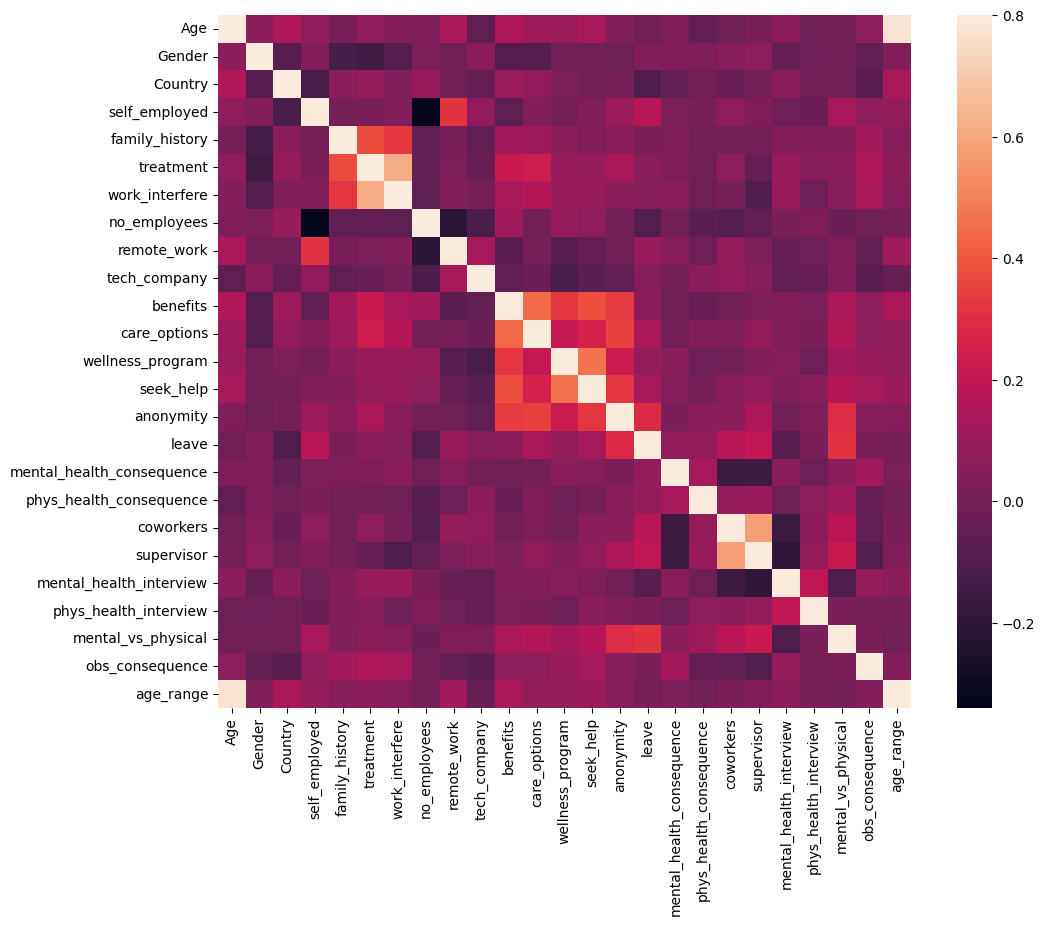

In [9]:
# Correlation Matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

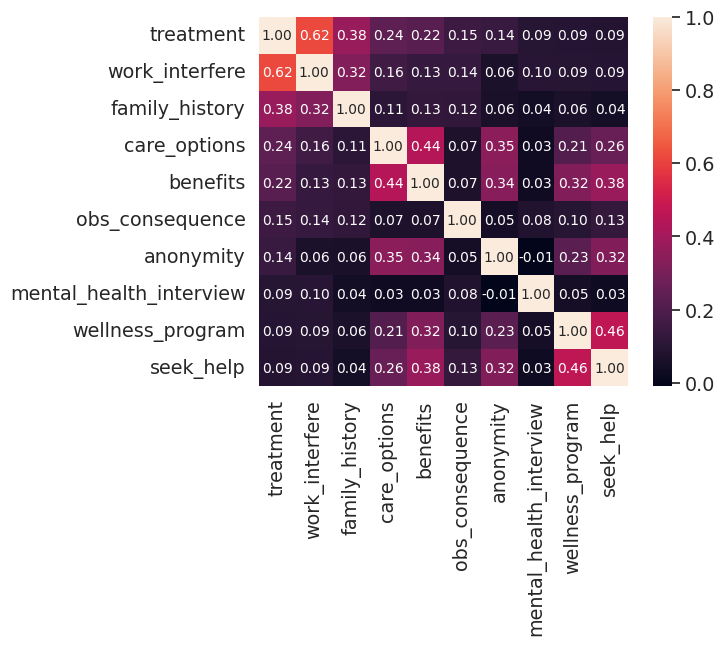

In [10]:
# Treatment correlation matrix
k = 10 # Number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Text(0.5, 0, 'Age')

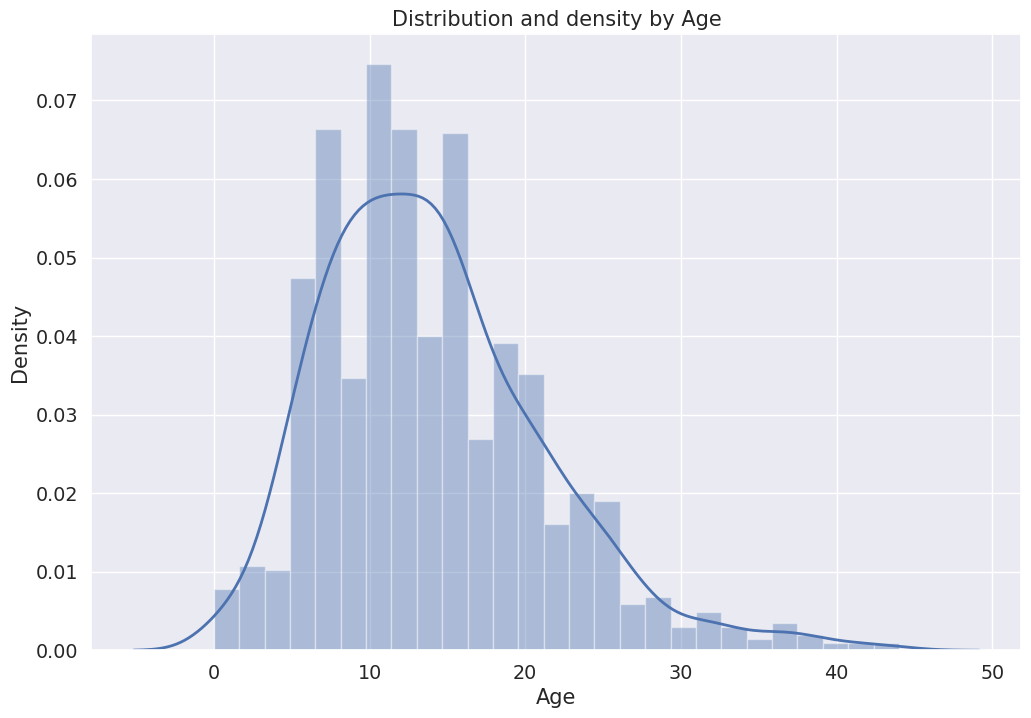

In [11]:
# Distribution and Density by Age
plt.figure(figsize=(12,8))
sns.histplot(df["Age"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4), line_kws={"lw": 2})
plt.title("Distribution and density by Age")
plt.xlabel("Age")

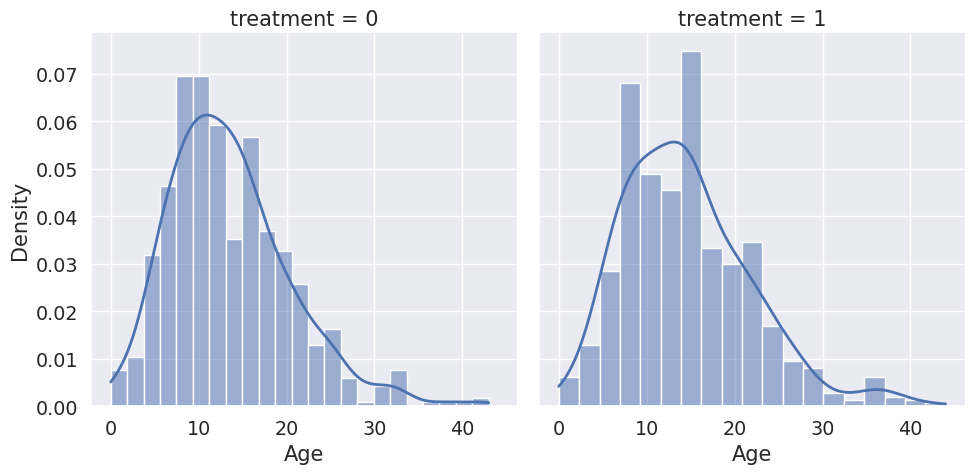

In [12]:
g = sns.FacetGrid(df, col='treatment', height=5)
g = g.map(sns.histplot, "Age", kde=True, stat="density", line_kws={"lw": 2})

<ipython-input-25-5b4a1776a8f7>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels)


Text(0.5, 1.0, 'Total Distribution by treated or not')

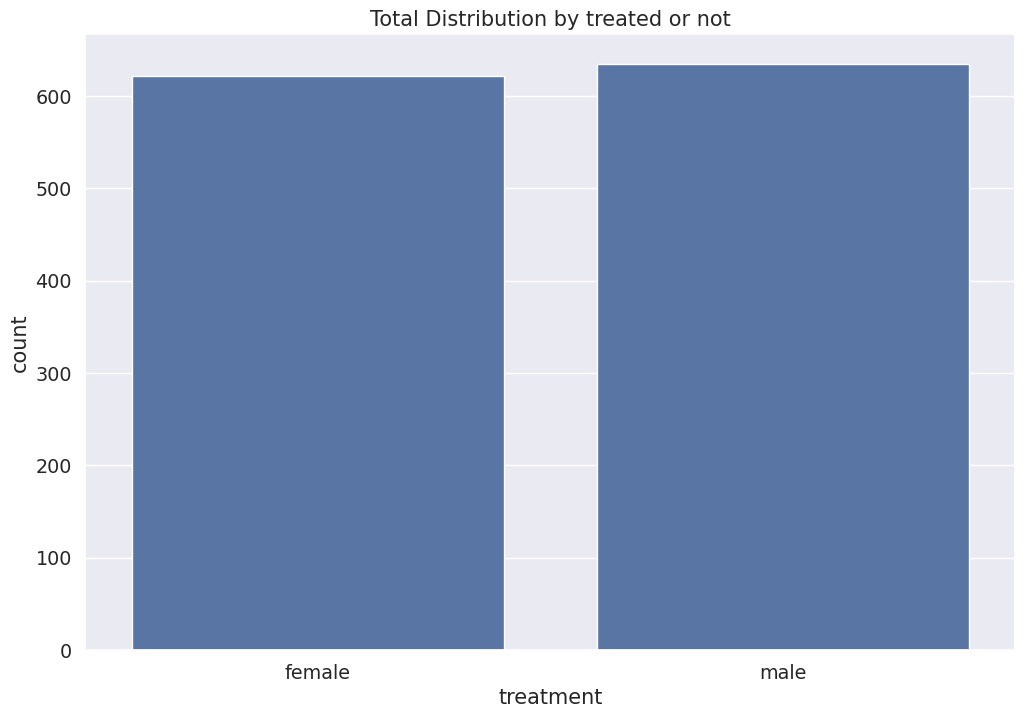

In [25]:
plt.figure(figsize=(12,8))
labels = labelDict['label_Gender']
g = sns.countplot(x="treatment", data=df)
g.set_xticklabels(labels)

plt.title('Total Distribution by treated or not')

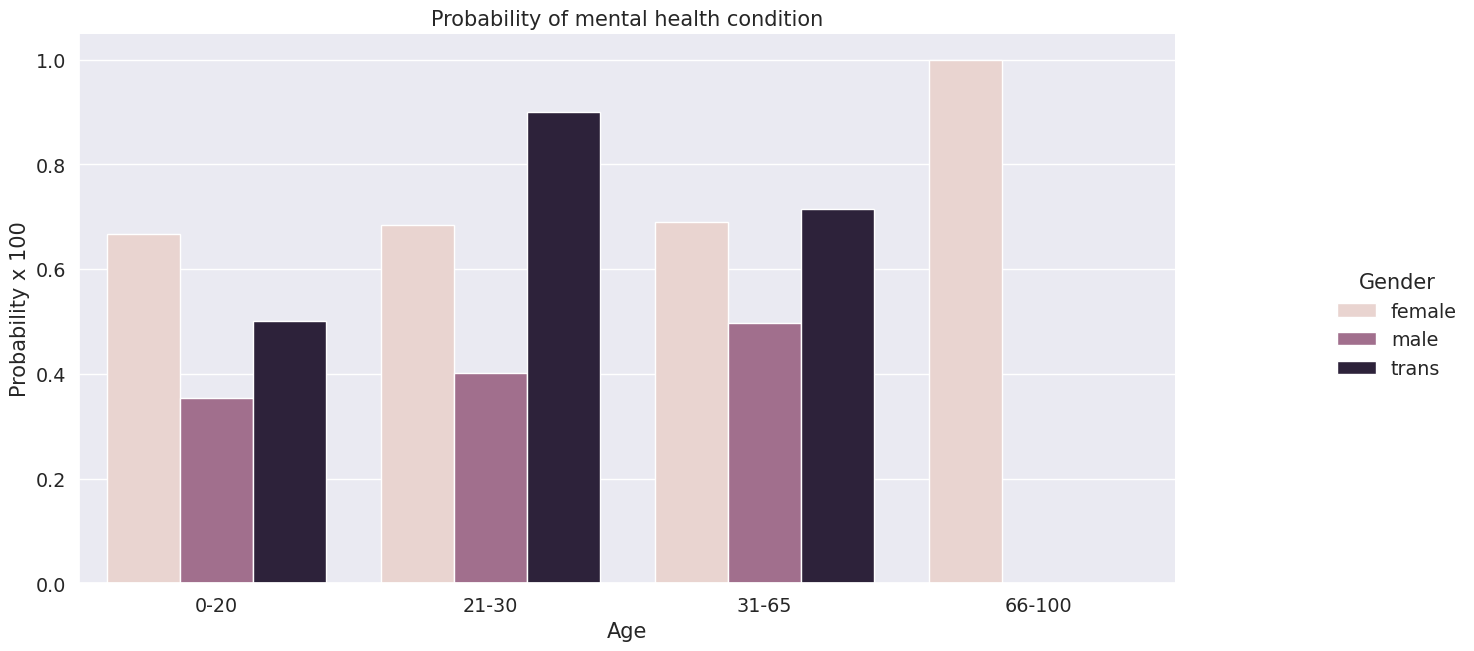

In [14]:
labels_age_range = labelDict['label_age_range']

# Create the plot with larger size
g = sns.catplot(x="age_range", y="treatment", hue="Gender", data=df, kind="bar", errorbar=None, height=7, aspect=2, legend_out=True)

# Set the tick positions and labels for x-axis
g.set_xticklabels(labels_age_range, rotation=0)

# Accessing the underlying axes object to set tick positions
for ax in g.axes.flat:
    ax.set_xticks(range(len(labels_age_range)))

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Age')

# Replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()

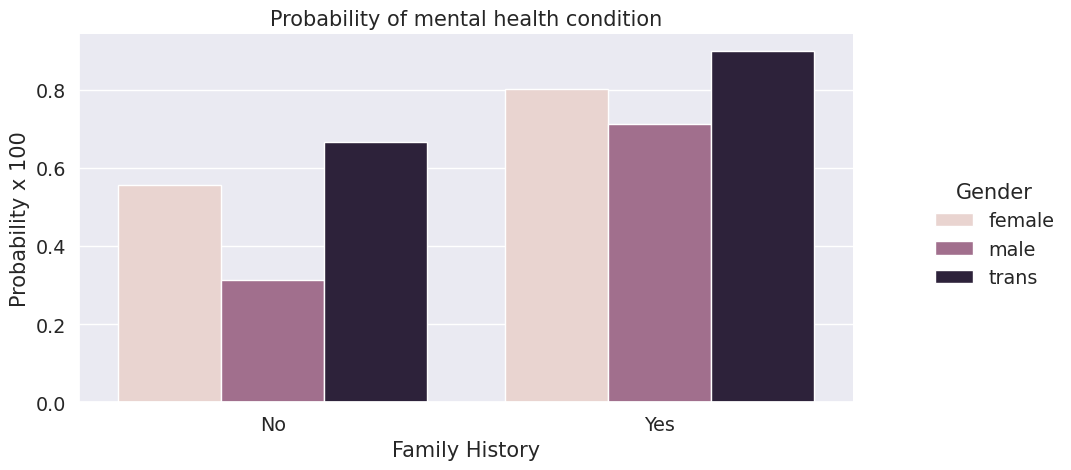

In [15]:
labels_family_history = labelDict['label_family_history']

# Create the plot
g = sns.catplot(x="family_history", y="treatment", hue="Gender", data=df, kind="bar", errorbar=None, height=5, aspect=2, legend_out=True)

# Set the tick positions and labels for x-axis
g.set_xticklabels(labels_family_history, rotation=0)

# Accessing the underlying axes object to set tick positions
for ax in g.axes.flat:
    ax.set_xticks(range(len(labels_family_history)))

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Family History')

# Replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()

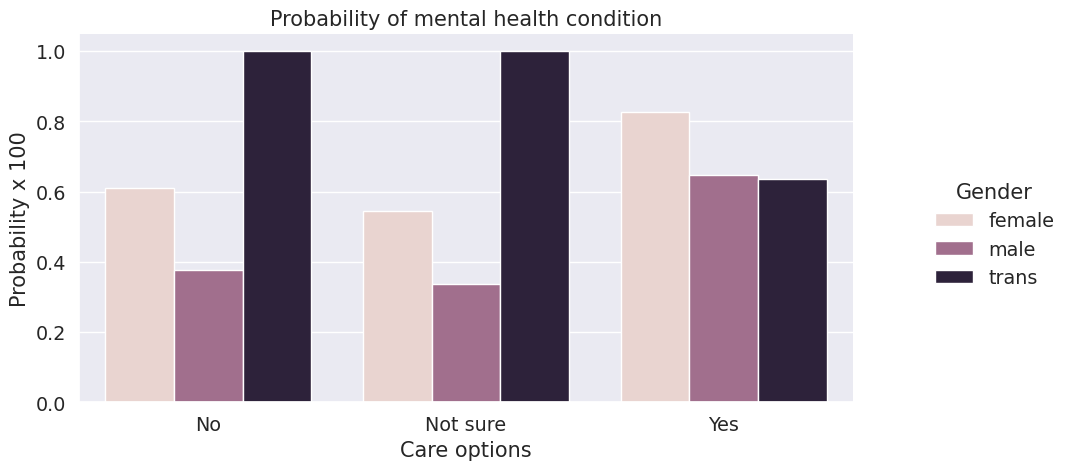

In [16]:
labels_care_options = labelDict['label_care_options']

# Create the plot
g = sns.catplot(x="care_options", y="treatment", hue="Gender", data=df, kind="bar", errorbar=None, height=5, aspect=2, legend_out=True)

# Set the tick positions and labels for x-axis
g.set_xticklabels(labels_care_options, rotation=0)

# Accessing the underlying axes object to set tick positions
for ax in g.axes.flat:
    ax.set_xticks(range(len(labels_care_options)))

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care options')

# Replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()

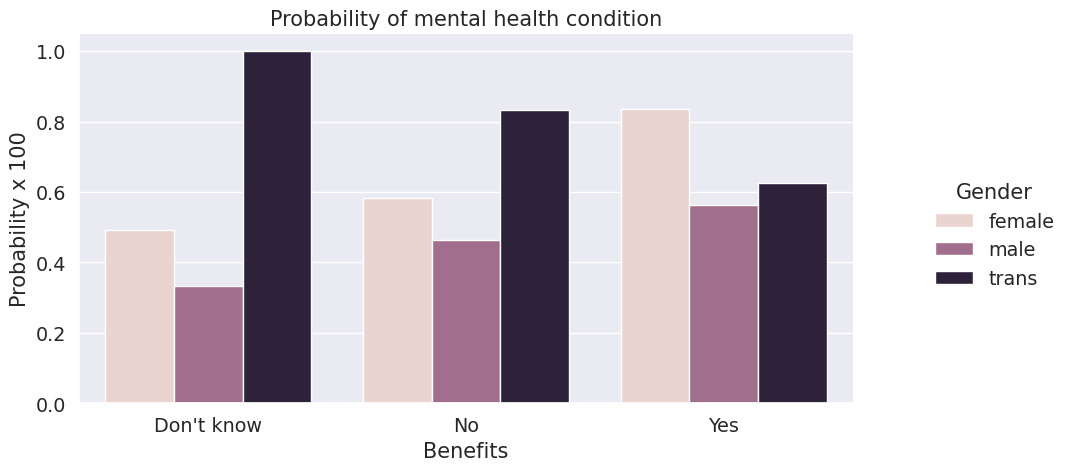

In [17]:
labels_benefits = labelDict['label_benefits']

# Create the plot
g = sns.catplot(x="benefits", y="treatment", hue="Gender", data=df, kind="bar", errorbar=None, height=5, aspect=2, legend_out=True)

# Set the tick positions and labels for x-axis
g.set_xticklabels(labels_benefits, rotation=0)

# Accessing the underlying axes object to set tick positions
for ax in g.axes.flat:
    ax.set_xticks(range(len(labels_benefits)))

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Benefits')

# Replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()

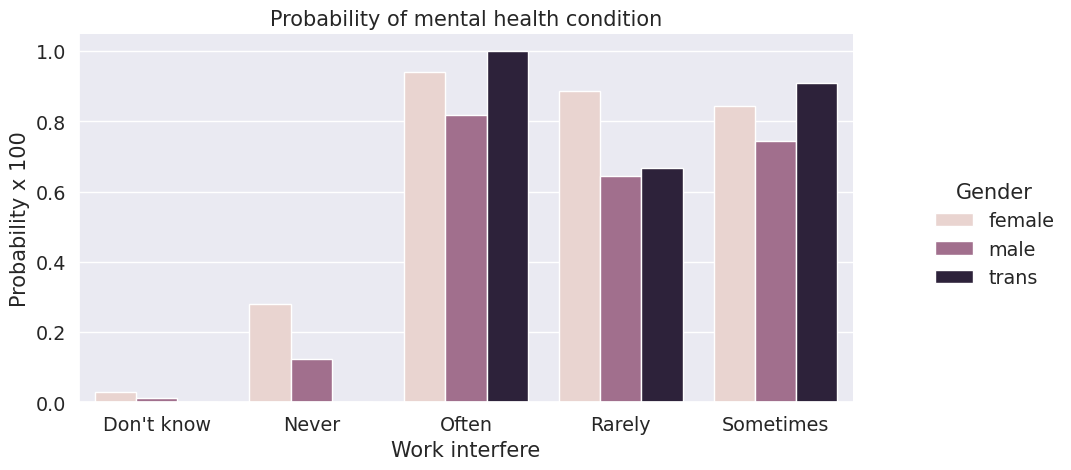

In [18]:
labels_work_interfere = labelDict['label_work_interfere']

# Create the plot
g = sns.catplot(x="work_interfere", y="treatment", hue="Gender", data=df, kind="bar", errorbar=None, height=5, aspect=2, legend_out=True)

# Set the tick positions and labels for x-axis
g.set_xticklabels(labels_work_interfere, rotation=0)

# Accessing the underlying axes object to set tick positions
for ax in g.axes.flat:
    ax.set_xticks(range(len(labels_work_interfere)))

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Work interfere')

# Replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9, right=0.8)

plt.show()

In [19]:
# Drop 'Country'
df = df.drop(['Country'], axis= 1)

print(df.isnull().sum())  ## NO NULL values

# Scaling Age
scaler = MinMaxScaler()
df['Age'] = scaler.fit_transform(df[['Age']])

Age                          0
Gender                       0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
age_range                    0
dtype: int64


In [20]:
feature_cols = ['Gender', 'self_employed', 'family_history', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
X = df[feature_cols]
y = df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

methodDict = {}
rmseDict = ()

In [21]:
# Model
classifier= RandomForestClassifier(n_estimators= 100, criterion="entropy", random_state=42)
classifier.fit(X_train, y_train)
y_pred= classifier.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy of RandomForestClassifier Model: ", accuracy*100)

Accuracy of RandomForestClassifier Model:  80.42328042328042


In [22]:
# Generate predictions with the best method
clf = AdaBoostClassifier()
clf.fit(X, y)
dfTestPredictions = clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, dfTestPredictions)
print("Accuracy of the AdaBoost Model: ", accuracy*100)

Accuracy of the AdaBoost Model:  81.74603174603175


In [23]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy of the KNN Model: ", accuracy*100)

Accuracy of the KNN Model:  78.3068783068783


In [24]:
import pickle
pickle.dump(classifier, open('model.pkl','wb'))

## *`Web App Page`*

In [ ]:
import pickle
import numpy as np

from flask import Flask, render_template, request
model = pickle.load(open('model.pkl', 'rb'))

app = Flask(__name__)


@app.route("/", methods=['GET'])
def home():
    return render_template('index.html')


@app.route("/accuracy", methods=['GET'])
def accuracy():
    return render_template('accuracy.html')


@app.route("/predict", methods=['POST'])
def predict():
    if request.method == 'POST':
        gender = request.form['Gender']
        self_employed = request.form['self_employed']
        family_history = request.form['family_history']
        work_interfere = request.form['work_interfere']
        no_employees = request.form['no_employees']
        remote_work = request.form['remote_work']
        tech_company = request.form['tech_company']
        anonymity = request.form['anonymity']
        leave = request.form['leave']
        mental_health_consequence = request.form['mental_health_consequence']
        phys_health_consequence = request.form['phys_health_consequence']
        coworkers = request.form['coworkers']
        supervisor = request.form['supervisor']
        mental_health_interview = request.form['mental_health_interview']
        phys_health_interview = request.form['phys_health_interview']
        mental_vs_physical = request.form['mental_vs_physical']
        obs_consequence = request.form['obs_consequence']
        benefits = request.form['benefits']
        care_options = request.form['care_options']
        wellness_program = request.form['wellness_program']
        seek_help = request.form['seek_help']

        arr = np.array([[gender, self_employed, family_history, work_interfere, no_employees, remote_work,
                         tech_company, anonymity, leave, mental_health_consequence, phys_health_consequence, coworkers,
                         supervisor, mental_health_interview, phys_health_interview, mental_vs_physical,  obs_consequence,
                         benefits, care_options,  wellness_program, seek_help]])

        pred = model.predict(arr)
        return render_template('predict.html',prediction=pred)


if __name__ == "__main__":
    app.run(debug=True)
